In [1]:
# General
import torch
import numpy as np
import matplotlib.pyplot as plt

# For dataloading
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For architecture and training
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-labels.tif
/kaggle/input/train-volume.tif
/kaggle/input/challenge-error-metrics.bsh
/kaggle/input/test-volume.tif
/kaggle/input/train-labels.tif


In [7]:
class ISBIDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.images = tiff.imread(image_path).astype(np.float32)
        self.masks = tiff.imread(mask_path).astype(np.float32)
        self.transform = transform

        # Normalize images and masks to [0, 1]
        self.images = (self.images - np.min(self.images)) / (np.max(self.images) - np.min(self.images))
        self.masks = self.masks / 255.0

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def __len__(self):
        return len(self.images)

# Creating Dataset and Dataloader
Official cite for dataset and leaderboard: https://imagej.net/events/isbi-2012-segmentation-challenge
### TODO:
- Create train-val split for validating model performance
- Create test dataset (check right-side pannel)

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ISBIDataset(
    image_path="/kaggle/input/train-volume.tif",
    mask_path="/kaggle/input/train-labels.tif",
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True
)

In [10]:
# Function to display an image and its corresponding mask
def show_pair(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

Number of training pairs: 30
Number of training batches: 8
Image batch shape: torch.Size([4, 1, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


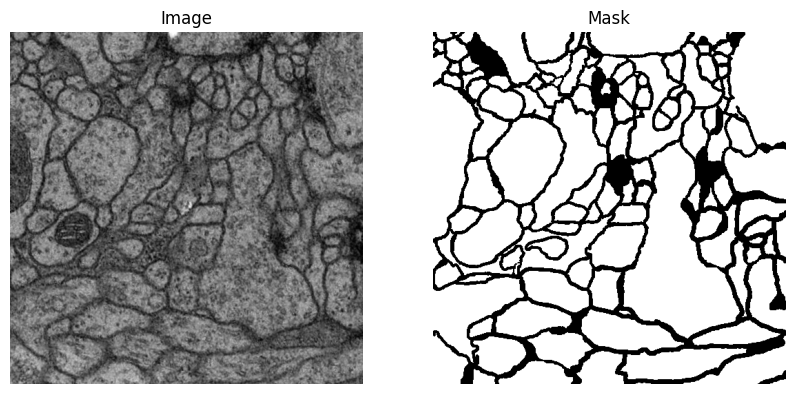

In [11]:
print(f'Number of training pairs: {len(train_dataset)}')
print(f'Number of training batches: {len(train_loader)}')

for image, mask in train_loader:
    print(f'Image batch shape: {image.shape}')
    print(f'Mask batch shape: {mask.shape}')

    show_pair(image[0], mask[0])

    break

# Model architecture
Read the paper and complete the code below

In [16]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.enc5 = CBR(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        # Decoder
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.final_conv(dec1)

# Training script

!!! Be very careful if your model is passing logits, the loss must use logits as well

In [17]:
model = UNet().cuda()  # Make sure you choose accelerator: GPU P100 by choosing it the top-right three-dots
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy with logits for binary segmentation
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20

print('Starting Training...')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.cuda()
        masks = masks.cuda()

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed!")

Starting Training...
Epoch [1/20], Loss: 0.5597
Epoch [2/20], Loss: 0.3920
Epoch [3/20], Loss: 0.3364
Epoch [4/20], Loss: 0.3008
Epoch [5/20], Loss: 0.2762
Epoch [6/20], Loss: 0.2658
Epoch [7/20], Loss: 0.2488
Epoch [8/20], Loss: 0.2351
Epoch [9/20], Loss: 0.2214
Epoch [10/20], Loss: 0.2154
Epoch [11/20], Loss: 0.2064
Epoch [12/20], Loss: 0.2021
Epoch [13/20], Loss: 0.2019
Epoch [14/20], Loss: 0.1950
Epoch [15/20], Loss: 0.1899
Epoch [16/20], Loss: 0.1883
Epoch [17/20], Loss: 0.1864
Epoch [18/20], Loss: 0.1838
Epoch [19/20], Loss: 0.1813
Epoch [20/20], Loss: 0.1765
Training completed!
